In [1]:
%pylab inline
import pandas as pd
from hscictools import bnf,ccg,gbq # my local stuff

Populating the interactive namespace from numpy and matplotlib


# Chemical cost structure of the BNF chapters

This notebook looks at spend on each BNF chapter using prinicipal component analysis (PCA) in order to

- gauge the "complexity" of the cost structure of each chapter through "explained variation". The fewer components needed to explain a good fraction of the chapter's variance, the simpler the cost structure of the chapter.
- gain insight into the concrete combinations of chemicals that are most aligned with the cost variation in each chapter



## BigQuery

For this analysis, we need costs for each (chemical, CCG) pair: quite a large result set.

In [2]:
df=gbq.query(
    '''
    select BNF_CHEMICAL,PCT,sum(ACT_COST) TOTAL_ACT_COST
    from [nhs.PDPI2]
    where PERIOD contains "2015"
    group by BNF_CHEMICAL, PCT
    ''',
    max_rows=500000,
    index=['BNF_CHEMICAL','PCT'],cast={'TOTAL_ACT_COST':float},
    cachedir='/var/gbq'
)

Reading cached results from /var/gbq/42c0b627b5d645728652864c4610f7cf.json
375817 rows converted to DataFrame in 0.87 seconds


In [3]:
df.head()

,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
200202010,10V,40780.35
212200001,10V,52229.32
0103010N0,10V,269.92
0105010B0,10V,279544.25
0202030C0,10V,9931.96


## CCG segmentation

Again the CCGs form two clusters. Let's keep only the cluster of CCGs prescribing the broader set of chemicals.

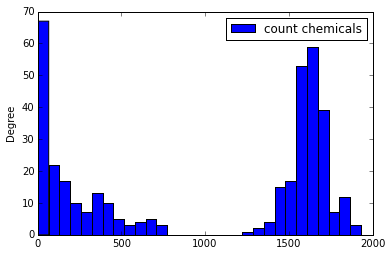

In [4]:
df.groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'}).plot(kind='hist',bins=30)

In [5]:
chemsperccg=df.groupby(level=1).count()
chemsperccg
ccgskeep=set(chemsperccg[chemsperccg['TOTAL_ACT_COST']>1000].index)
len(ccgskeep)

212

Let's apply this restriction to the main dataframe and map the CCG ids to names for readability.

In [6]:
dfkeep=df[df.index.map(lambda i:i[1] in ccgskeep and i[1] in ccg.ccgs())]
print "(chemical,ccg pairs) remaining:",len(dfkeep)
dfkeep.head()

(chemical,ccg pairs) remaining: 343942


,,TOTAL_ACT_COST
BNF_CHEMICAL,PCT,
200202010,10V,40780.35
212200001,10V,52229.32
0103010N0,10V,269.92
0105010B0,10V,279544.25
0202030C0,10V,9931.96


## CCG-chapter level aggregation

Let's compute the fractional cost of each chemical inside a (CCG,chapter) pair.

First, let's add the chapters into the dataframes index (as first 2 chars of BNF chemical code).

While we're at it, let's also decode the CCG ids to names.

In [7]:
dfkeep.index=pd.MultiIndex.from_tuples(dfkeep.index.map(lambda i: (i[0],
                                                                   "%s (%s)" % (bnf.description(i[0][:2]),i[0][:2]),
                                                                   ccg.name(i[1])
                                                                  )))
dfkeep.index.set_names(['BNF_CHEMICAL','BNF_CHAPTER','CCG'],inplace=True)
dfkeep.head()

,,,TOTAL_ACT_COST
BNF_CHEMICAL,BNF_CHAPTER,CCG,
200202010,Dressings (20),NHS SOUTH EASTERN HAMPSHIRE CCG,40780.35
212200001,Appliances (21),NHS SOUTH EASTERN HAMPSHIRE CCG,52229.32
0103010N0,Gastro-Intestinal System (01),NHS SOUTH EASTERN HAMPSHIRE CCG,269.92
0105010B0,Gastro-Intestinal System (01),NHS SOUTH EASTERN HAMPSHIRE CCG,279544.25
0202030C0,Cardiovascular System (02),NHS SOUTH EASTERN HAMPSHIRE CCG,9931.96


### Some chapters are too thin for this analysis

It's worth checking to see how many distinct chemicals are described from each chapter.

,count chemicals
BNF_CHAPTER,
Preparations used in Diagnosis (18),1
Other Drugs And Preparations (19),24
Anaesthesia (15),25
Immunological Products & Vaccines (14),29
"Obstetrics,Gynae+Urinary Tract Disorders (07)",67
Malignant Disease & Immunosuppression (08),72
"Ear, Nose And Oropharynx (12)",76
Musculoskeletal & Joint Diseases (10),85
Respiratory System (03),91


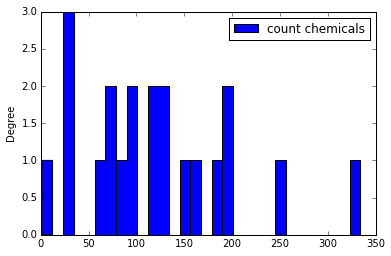

In [8]:
chemicalsperchapter=dfkeep.groupby(level=[0,1]).sum().groupby(level=1).count().rename(columns={'TOTAL_ACT_COST':'count chemicals'})
display(chemicalsperchapter.sort(columns=['count chemicals']))
chemicalsperchapter.plot(kind='hist',bins=30)

Some chapters have a tiny number of chemicals being prescribed so let's exclude them, and take only those with more than 30.

In [9]:
broadchapters=set(chemicalsperchapter[chemicalsperchapter['count chemicals']>30].index)
dfkeep2=dfkeep[dfkeep.index.map(lambda i: i[1] in broadchapters)]
# I had to rebuild index here; otherwise it was keeping hold of unwanted entries (index entries with no rows). Not sure why...
# Independently noted here: http://stackoverflow.com/questions/30941425/updating-pandas-multiindex-after-indexing-the-dataframe
dfkeep2=dfkeep2.reset_index().set_index(['BNF_CHEMICAL','BNF_CHAPTER','CCG'])

### Actually compute the fractions

This is a one-liner using pandas (though not the most obvious...)

In [10]:
# need to work around pandas limitation for joining across multiple index columns
fracs=dfkeep2.unstack(0).div(dfkeep2.groupby(level=[1,2]).sum().squeeze(),axis=0).stack()
fracs.columns=['FRAC_CCG_CHAPTER_COST']
fracs.index=fracs.index.swaplevel(1,2)
fracs.head()

FRAC_CCG_CHAPTER_COST
BNF_CHAPTER     BNF_CHEMICAL CCG                                                           
Appliances (21) 210101001    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           9.321916e-06
                210102201    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           5.860607e-05
                210102301    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           3.571778e-02
                210106001    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           5.317871e-07
                210109004    NHS AIREDALE, WHARFEDALE AND CRAVEN CCG           9.689036e-03

## Explained variance analysis

Now we have the fractions on our well behaved domain of CCGs and chapters, we can do the PCA.

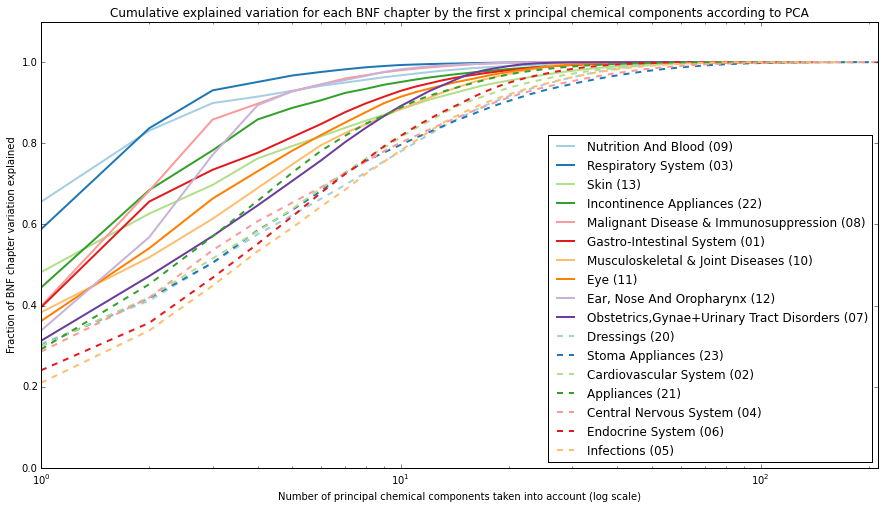

In [11]:
from sklearn.decomposition import PCA
evrlist=list() # list to hold a data frame for each chapter, which will then get concatanated to produce single dataframe of the final results
for chapter in fracs.index.levels[0]:
    crosstab=fracs.ix[chapter].unstack(0).fillna(0)
    pca=PCA()
    pca.fit_transform(crosstab)
    chapter_evr=pd.DataFrame(pca.explained_variance_ratio_,columns=['EVR'])
    chapter_evr.index=chapter_evr.index.map(lambda i:i+1)
    evrlist.append(chapter_evr)
    
evr=pd.concat(evrlist,keys=fracs.index.levels[0])
evr.index=evr.index.swaplevel(0,1) # makes it easier to find variance explained by more significant component
colors='#a6cee3,#1f78b4,#b2df8a,#33a02c,#fb9a99,#e31a1c,#fdbf6f,#ff7f00,#cab2d6,#6a3d9a'.split(',')
style=['-']*len(colors)+['--']*len(colors)
evr_unstacked=evr.unstack(1)['EVR'][evr.ix[1].sort(columns='EVR',ascending=False).index].cumsum()
ax=evr_unstacked.plot(logx=True,figsize=(15,8),linewidth=2,color=colors,style=style,ylim=0,
                      title='Cumulative explained variation for each BNF chapter by the first x principal chemical components according to PCA')
ax.set_xlabel("Number of principal chemical components taken into account (log scale)")
ax.set_ylabel("Fraction of BNF chapter variation explained")

## Principal component composition

Let's look at the concrete principal components the chapters. These are combinations of the chemicals that are most aligned to the axes of variance of the chapter.

I list the first few for each chapter, with the chapters in descending order of "simplicity".

I'm reporting the first 3 principal components for each chapter; and for each principal component I list the chemical constituents with weight above 10%.

In [12]:
def describe_principal_components(chapter,ncts=3,minw=0.1):
    print chapter,"\n"
    crosstab=fracs.ix[chapter].unstack(0).fillna(0)
    pca=PCA()
    pca.fit(crosstab)
    for i,princomp in enumerate(range(ncts)):
        print "\tPrincipal component %i - explains %.2f%% of the variance:\n" % (princomp,100*pca.explained_variance_ratio_[i])
        
        chems=list()
        for i,w in enumerate(pca.components_[princomp]):

            if abs(w)>minw:
                chems.append((abs(w),w,"%s (%s)" % (bnf.path(crosstab.columns[i][1])[-1],crosstab.columns[i][1])))
        for a,w,c in sorted(chems,reverse=True):
            print "\t\t%s: %s" % (c,w)
        print
       
for ch in evr.ix[1].sort(columns='EVR',ascending=False).index:
    describe_principal_components(ch,ncts=3,minw=0.1)
    print "="*80

Nutrition And Blood (09) 

	Principal component 0 - explains 65.56% of the variance:

		Enteral Nutrition (090402000): -0.869524830611
		Colecalciferol (0906040G0): 0.47609070148
		Other Food For Special Diet Preps (090401000): 0.106756923378

	Principal component 1 - explains 17.57% of the variance:

		Other Food For Special Diet Preps (090401000): 0.870075059189
		Colecalciferol (0906040G0): -0.447539642062
		Enteral Nutrition (090402000): -0.142144224667

	Principal component 2 - explains 6.79% of the variance:

		Colecalciferol (0906040G0): -0.715873646574
		Enteral Nutrition (090402000): -0.42859359059
		Other Food For Special Diet Preps (090401000): -0.409539873378
		Sevelamer (0905022S0): 0.195825746782
		Darbepoetin Alfa (0901030J0): 0.157917519836
		Vitamin B Compound (0906027G0): 0.15478504008

Respiratory System (03) 

	Principal component 0 - explains 58.80% of the variance:

		Fluticasone Propionate (Inh) (0302000N0): -0.82666107962
		Budesonide (0302000K0): 0.493218566595

## Some potentially interesting examples

Let's pick out a few pairs of chemicals from the report above whose usage seems to be anti-correlated.

In [14]:
fracs_ccg_chemical=fracs.unstack(1)['FRAC_CCG_CHAPTER_COST']
def chemical_scatter(x,y):
    fracs_ccg_chemical.plot(kind='scatter',x=x,y=y,
                            title='CCG scatter in [%s] for [%s] on x and [%s] on y\n' \
                                  % (bnf.path(x[:6])[-1],bnf.path(x)[-1],bnf.path(y)[-1]))

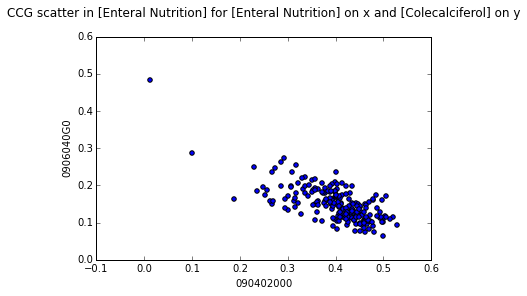

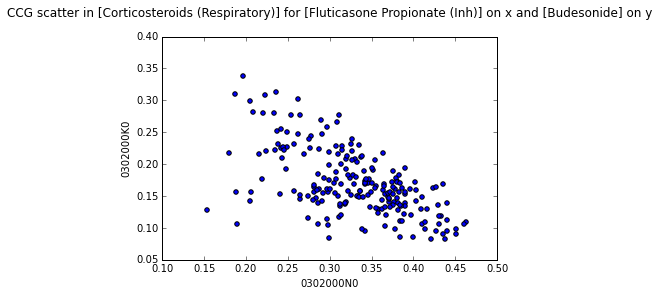

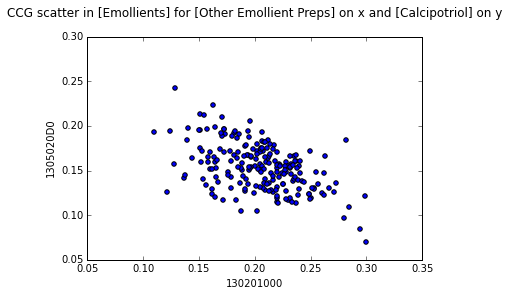

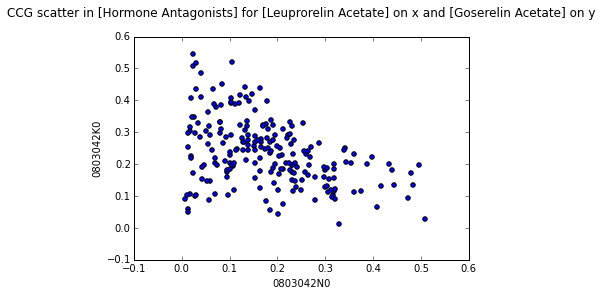

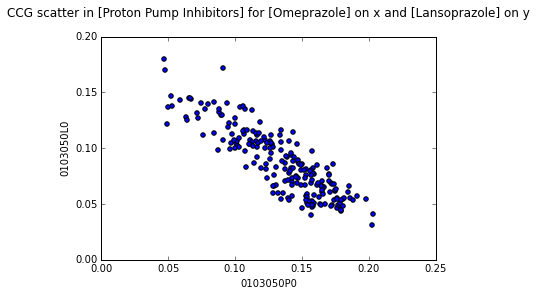

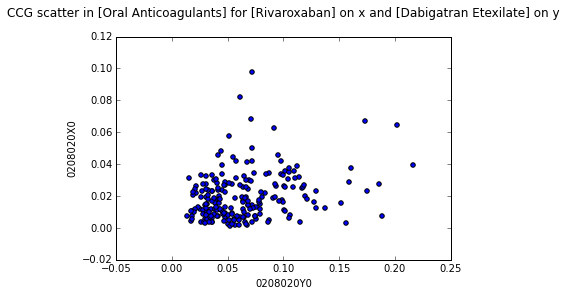

In [22]:
chemical_scatter('090402000','0906040G0')
chemical_scatter('0302000N0','0302000K0')
chemical_scatter('130201000','1305020D0')
chemical_scatter('0803042N0','0803042K0')


chemical_scatter('0103050P0','0103050L0')
chemical_scatter('0208020Y0','0208020X0')